# Training Denoisers with Noise Texture Augmentation

The goal of this notebook is to introduce the noise texture augmentation loop previously introduced in [00_characterizing_noise_augmentation.ipynb](00_characterizing_noise_augmentation.ipynb) as well as provides a mean for selecting the $\lambda$ parameter controlling the amount of data augmentation.

![augmented training](images/for_word/augmented.png)
*Figure 1b In noise texture augmented training noise patches are added to the low noise training target to make new augmented inputs. While training, a proportion λ of the training data mini batch is from the augmented inputs while the remaining 1 − λ is from the original low dose training inputs.*

If reproducing these figures on your own local dataset, replace `base_dir` with your download location of the dataset available for download at [Zenodo](https://zenodo.org/doi/10.5281/zenodo.10064035)

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11267694.svg)](https://doi.org/10.5281/zenodo.11267694)

These phantom simulations were generated using the [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms), please see the associated [documentation](https://pediatriciqphantoms.readthedocs.io/en/latest/?badge=latest) on how to rerun the simulations under different imaging conditions.

In [1]:
from pathlib import Path
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/')

In [2]:
import os
import sys
sys.path.append('../denoising')
from torch.backends import cudnn
from loader import get_loader
from solver import Solver
from networks import RED_CNN
from subprocess import run
import torch
import numpy as np
from pathlib import Path

In [3]:
from collections import OrderedDict

def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

If interested in retraining models, the Mayo Clinic Low Dose Grand Challenge (LDGC) dataset is available for download from the Cancer Imaging Archive: [https://doi.org/10.7937/9npb-2637](https://www.cancerimagingarchive.net/collection/ldct-and-projection-data/) for more information on the dataset please see [CTCIC/patient-ct-projection-data-library](https://ctcicblog.mayo.edu/patient-ct-projection-data-library/)

In [4]:
ldgc_path = '/gpfs_projects/brandon.nelson/Mayo_LDGC'

In [5]:
from pathlib import Path
model_path = Path('models')

if model_path.exists():
    for lmbda in range(11):
        lmbda/=10
        model_path = Path(f'models/lambda{int(lmbda*100):03d}')
        model = load_model(model_path)
        print(model_path)
else:
    for lmbda in range(11):
        lmbda/=10
        run(['python', '../../denoising/main.py',
             '--data_path' ,f'{ldgc_path}/images',
             '--saved_path', f'{ldgc_path}/numpy_files',
             '--load_mode', '1',
             '--save_path', f'models/lambda{int(lmbda*100):03d}',
             '--augment', f'{lmbda}'])

models/lambda000
models/lambda010
models/lambda020
models/lambda030
models/lambda040
models/lambda050
models/lambda060
models/lambda070
models/lambda080
models/lambda090
models/lambda100


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import SimpleITK as sitk

base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
meta = pd.read_csv(base_dir / 'metadata.csv')
meta = meta[meta.recon == 'fbp']
meta.head()

,Code #,Name,age [year],gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,effective diameter [cm],Dose [%],recon,phantom,file,simulated,FOV [cm],kernel,scanner
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
5,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,40,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
8,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,25,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
11,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,55,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
14,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,100,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN


In [7]:
meta.phantom.unique()

array(['anthropomorphic', 'MITA-LCD', 'uniform', 'ACR464', 'CTP404'],
      dtype=object)

In [8]:
meta.simulated.unique()

array([ True, False])

In [9]:
import sys
sys.path.append('..')

from utils import circle_select, get_circle_diameter, load_mhd, ctshow

In [10]:
fname = meta[(meta['Dose [%]'] == 25) &
             (meta.phantom == 'uniform') &
             (meta['effective diameter [cm]'] == 21.6)].file.item() #try different phantom sizes and compare if lambda value changes

In [11]:
img = sitk.ReadImage(fname)
vol = sitk.GetArrayFromImage(img)
vol.shape

(200, 512, 512)

In [12]:
%matplotlib inline


In [13]:
r = get_circle_diameter(vol[0])/2
r

232.42625138671843

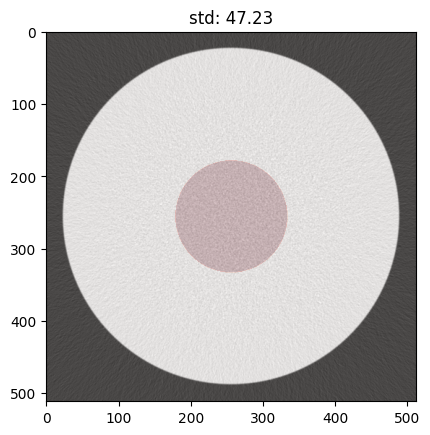

In [14]:
roi = circle_select(vol[0], (vol[0].shape[0]//2, vol[0].shape[1]//2), r/3)
plt.imshow(vol[0], cmap='gray')
plt.imshow(roi, cmap='Reds', alpha=0.2)
plt.title(f'std: {vol[0][roi].std():2.2f}')
plt.show()

In [15]:
denoised = model.predict(vol[:20])

  0%|                                                                                                                                                                                                                                                 | 0/20 [00:00<?, ?it/s]

  5%|███████████▋                                                                                                                                                                                                                             | 1/20 [00:01<00:23,  1.24s/it]

 10%|███████████████████████▎                                                                                                                                                                                                                 | 2/20 [00:02<00:19,  1.06s/it]

 15%|██████████████████████████████████▉                                                                                                                                                                                                      | 3/20 [00:03<00:17,  1.01s/it]

 20%|██████████████████████████████████████████████▌                                                                                                                                                                                          | 4/20 [00:04<00:15,  1.02it/s]

 25%|██████████████████████████████████████████████████████████▎                                                                                                                                                                              | 5/20 [00:04<00:14,  1.04it/s]

 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 6/20 [00:05<00:13,  1.05it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 7/20 [00:06<00:12,  1.05it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 8/20 [00:07<00:11,  1.06it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 9/20 [00:08<00:10,  1.07it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 10/20 [00:09<00:09,  1.07it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 11/20 [00:10<00:08,  1.07it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 12/20 [00:11<00:07,  1.06it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 13/20 [00:12<00:06,  1.07it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 14/20 [00:13<00:05,  1.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 15/20 [00:14<00:04,  1.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 16/20 [00:15<00:03,  1.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 17/20 [00:16<00:02,  1.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 18/20 [00:17<00:01,  1.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 19/20 [00:18<00:00,  1.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]

In [16]:
denoised[:,roi].std(axis=1).mean()

28.95023

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
redcnn = load_model(f'models/lambda{int(0):03d}').to(device)

cuda


In [18]:
phantom = 'uniform'
doses = []
stds = []
means = []
imgs = []
diams = []
fovs=[]
lambdas = []
recons = []
img_dict = {}

batch_size = 20

results_csv = Path('lambda_vals.csv')

if results_csv.exists():
    df = pd.read_csv('lambda_vals.csv')
else:
    redcnn = load_model(f'models/lambda{int(0):03d}').to(device)
    for recon in ['fbp', 'RED-CNN', 'RED-CNN augmented']:
        for dose in [25, 100]:
            for diam in meta[meta.phantom==phantom]['effective diameter [cm]'].unique():
                vol = load_mhd(meta[(meta['Dose [%]'] == dose) &
                             (meta.phantom == phantom) &
                             (meta['effective diameter [cm]'] == diam)].file.item()) #try different phantom sizes and compare if lambda value changes
                fov=meta[(meta['Dose [%]'] == dose) &
                             (meta.phantom == phantom) &
                             (meta['effective diameter [cm]'] == diam)]['FOV [cm]'].item()
                lambda_dict = {}
                for lmbda in range(11):
                    lmbda/=10
                    if recon == 'RED-CNN':
                        model_path = Path(f'models/lambda{int(0):03d}')
                    else:
                        model_path = Path(f'models/lambda{int(lmbda*100):03d}')
                    if (recon == 'fbp'):
                        denoised = vol
                    else:
                        model = load_model(model_path).to(device)
                        denoised = model.predict(vol[:, None], device=device, batch_size=batch_size).squeeze()
                    roi = circle_select(vol[0], (vol[0].shape[0]//2, vol[0].shape[1]//2), r/3)
                    # ctshow(denoised[0])
                    plt.imshow(roi, cmap='Reds', alpha=0.05)
                    std = denoised[:, roi].std(axis=1).mean()
                    mean = denoised[:, roi].std(axis=1).mean()
                    # plt.title(f'{recon} {dose}% dose\ndiam: {diam} cm, $\lambda$: {lmbda} std: {std:2.2f}')
                    # plt.show()
                    doses.append(dose)
                    stds.append(std)
                    means.append(mean)
                    diams.append(diam)
                    lambdas.append(lmbda)
                    fovs.append(fov)
                    recons.append(recon)
                    lambda_dict[lmbda] = denoised[0]
                img_dict[diam] = lambda_dict
    df = pd.DataFrame({'effective diameter [cm]':diams,
                       'FOV [cm]':fovs,
                       'Dose [%]': doses,
                       'recon': recons,
                       'lambda': lambdas,
                       'mean [HU]': means,
                       'std [HU]': stds})
    df.to_csv('lambda_vals.csv', index=False)

In [19]:
df

,effective diameter [cm],FOV [cm],Dose [%],recon,lambda,mean [HU],std [HU]
0,35.0,39.0,25,fbp,0.0,46.542552,46.542552
1,35.0,39.0,25,fbp,0.1,46.542552,46.542552
2,35.0,39.0,25,fbp,0.2,46.542552,46.542552
3,35.0,39.0,25,fbp,0.3,46.542552,46.542552
4,35.0,39.0,25,fbp,0.4,46.542552,46.542552
...,...,...,...,...,...,...,...
523,15.1,17.0,100,RED-CNN augmented,0.6,7.009116,7.009116
524,15.1,17.0,100,RED-CNN augmented,0.7,7.847940,7.847940
525,15.1,17.0,100,RED-CNN augmented,0.8,6.893947,6.893947
526,15.1,17.0,100,RED-CNN augmented,0.9,8.152204,8.152204


Add hi dose and low dose values...

In [20]:
df['effective diameter [cm]'].unique()

array([35. , 11.2, 18.5, 20. , 21.6, 13.1, 29.2, 15.1])

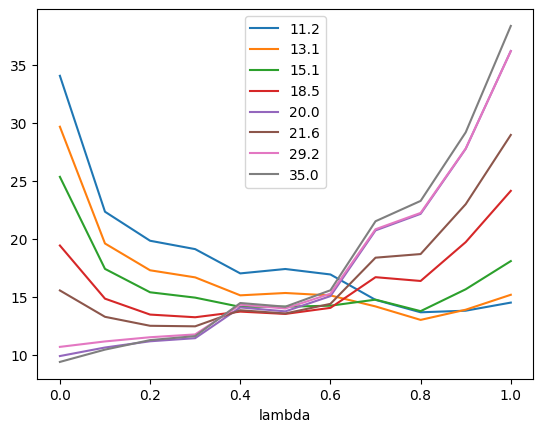

In [21]:
f, ax = plt.subplots()
for diam in sorted(df['effective diameter [cm]'].unique()):
    df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==diam)].plot(x='lambda', y='std [HU]', label=diam,ax=ax)
plt.show()

This plot is really interesting too, in the transition of child sizes (around 19-20 cm) the plot switches from a downward slope with less noise (more performance at higher lambda) to upward slope, so the decision in lambda value really depends on your intended population. For the paper I took the average across pediatric sizes but it could be valuable to show both

In [22]:
df.columns

Index(['effective diameter [cm]', 'FOV [cm]', 'Dose [%]', 'recon', 'lambda',
       'mean [HU]', 'std [HU]'],
      dtype='object')

In [23]:
sorted(df['FOV [cm]'].unique())

[12.0, 14.0, 17.0, 20.0, 24.0, 32.0, 34.0, 39.0]

In [24]:
means = df.groupby(['recon', 'Dose [%]', 'lambda']).mean()
means

effective diameter [cm]  FOV [cm]  mean [HU]  \
recon   Dose [%] lambda                                                 
RED-CNN 25       0.0                     20.4625      24.0  19.245397   
                 0.1                     20.4625      24.0  19.245397   
                 0.2                     20.4625      24.0  19.245397   
                 0.3                     20.4625      24.0  19.245397   
                 0.4                     20.4625      24.0  19.245397   
...                                          ...       ...        ...   
fbp     100      0.6                     20.4625      24.0  23.508144   
                 0.7                     20.4625      24.0  23.508144   
                 0.8                     20.4625      24.0  23.508144   
                 0.9                     20.4625      24.0  23.508144   
                 1.0                     20.4625      24.0  23.508144   

                          std [HU]  
recon   Dose [%] lambda             
RED-CNN 25       0.0     19.245397  
                 0.1     19.245397  
                 0.2     19.245397  
                 0.3     19.245397  
                 0.4     19.245397  
...                            ...  
fbp     100      0.6     23.508144  
                 0.7     23.508144  
                 0.8     23.508144  
                 0.9     23.508144  
                 1.0     23.508144  

[66 rows x 4 columns]

## Figure 3

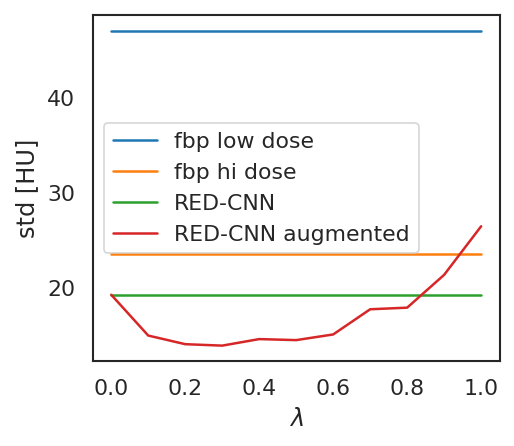

In [25]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('white')
f, ax = plt.subplots(figsize=(3.5, 3), dpi=150)
means['std [HU]']['fbp', 25].plot(ax=ax, label='fbp low dose')
means['std [HU]']['fbp', 100].plot(ax=ax, label='fbp hi dose')
means['std [HU]']['RED-CNN', 25].plot(ax=ax, label='RED-CNN')
means['std [HU]']['RED-CNN augmented', 25].plot(ax=ax, label='RED-CNN augmented')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('std [HU]')
plt.legend()
plt.savefig('results/fig3_lambda_selection.png')

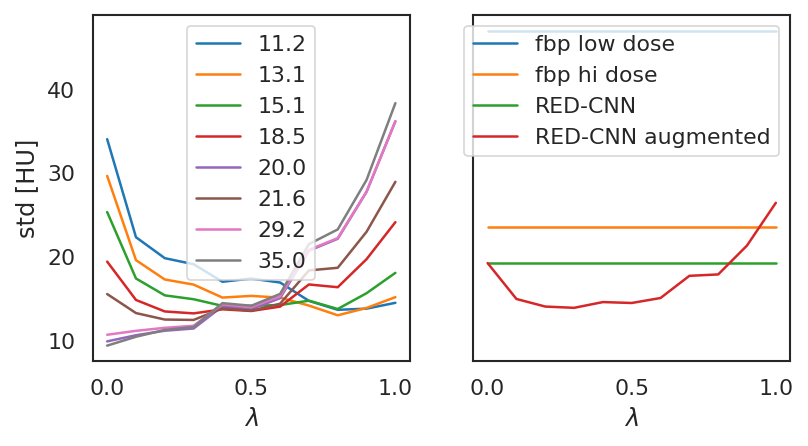

In [26]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('white')

f, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=150, sharex=True, sharey=True)

for diam in sorted(df['effective diameter [cm]'].unique()):
    df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==diam)].plot(x='lambda', y='std [HU]', label=diam,ax=axs[0])
axs[0].set_xlabel('$\lambda$')
axs[0].set_ylabel('std [HU]')

means['std [HU]']['fbp', 25].plot(ax=axs[1], label='fbp low dose')
means['std [HU]']['fbp', 100].plot(ax=axs[1], label='fbp hi dose')
means['std [HU]']['RED-CNN', 25].plot(ax=axs[1], label='RED-CNN')
means['std [HU]']['RED-CNN augmented', 25].plot(ax=axs[1], label='RED-CNN augmented')
axs[1].set_xlabel('$\lambda$')
axs[1].set_ylabel('std [HU]')
plt.legend()

<Axes: xlabel='lambda'>

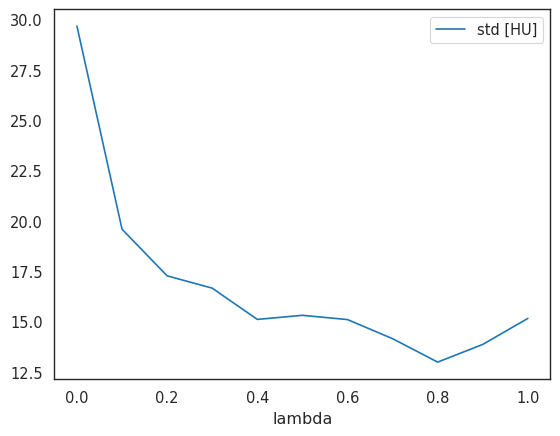

In [27]:
df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==13.1)].plot(x='lambda', y='std [HU]')

<Axes: xlabel='lambda', ylabel='std [HU]'>

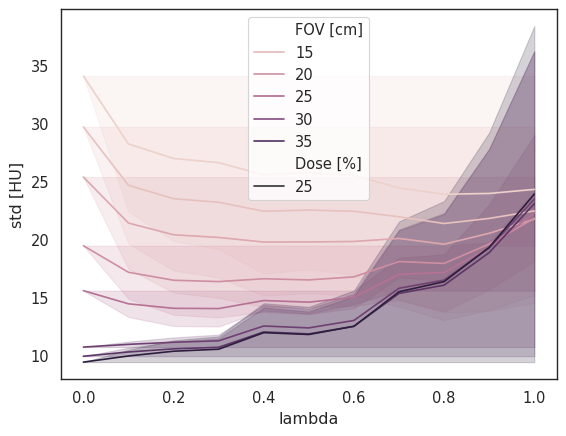

In [28]:
sns.lineplot(data=df[(df.recon!='fbp')&(df['Dose [%]']==25)], x='lambda', y='std [HU]', hue='FOV [cm]', style='Dose [%]')